In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import os
# Change working directory to the root of the project, try to be cautious with this implementation since it will break if the cell is run more than once
os.chdir(r"..")

import pandas as pd
from resources.constants import *

OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"

pictures_df = pd.read_csv(PICTURE_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)
user_triplets_df = pd.read_csv(USER_ACTIVITY_TRIPLETS_CSV_PATH, sep=CSV_SEPARATOR)

embeddings_df = pd.read_pickle(OUTFIT_EMBEDDINGS_DF_PATH)

In [2]:
embeddings_df.head(2)

,group,id,name,description,owner,timeCreated,retailPrice,meta.validTo,outfit_tags,tag_categories,...,picture_ids,num_pictures,lead_embedding,lead_picture_id,num_positive_examples,filtered_tags,filtered_categories,one_hot_encoded,concatenated_embeddings,outfit_embeddings
0,group.00064a241ade73e6a5a7ad36327e4e83,outfit.d138f31106ac442f9b2e0fe163597405,New Justine Coat,"The Justine Coat features a high neck, a hidde...",user.3b5555d48f6b473f8e58956aadc0e21f,2021-10-01 10:48:04.675,3500.0000,9999-01-01 00:00:00,"[Synthetic, Multi Season, Everyday, Day Birger...","[Material, Seasons, Occasion, Brand, Size, Col...",...,[picture.7040fcb864074b28bae3c09f66972ed0],1,"[0.007065, -0.04868, -0.05066, 0.1659, 1.448, ...",picture.7040fcb864074b28bae3c09f66972ed0,186,"[Synthetic, Multi Season, Everyday, Day Birger...","[Material, Seasons, Occasion, Brand, Color, Ge...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12740439176559448, 0.11191237717866898, 0.4..."
1,group.000957e12deba05e437a5e9726e8002c,outfit.93826cc51216dcd0,Sophisticated Dress,This dress is perfect for a summer night out w...,user.15bee69d2f1541d785eee3f047ec5cf9,2017-05-08 13:28:30.000,10000.0000,9999-01-01 00:00:00,"[Fall, Dresses, XS, Prada, Grey, Women, Business]","[Seasons, Category, Size, Brand, Color, Gender...",...,"[picture.bdfc85951b9babcf, picture.b80df15a205...",6,"[-0.0823, -0.131, 0.2832, -0.1334, -0.08594, -...",picture.bdfc85951b9babcf,1716,"[Fall, Grey, Women, Business]","[Seasons, Color, Gender, Occasion]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.7615255117416382, 0.6740720868110657, 0.999..."


In [4]:
# Define a distance function
from scipy.spatial.distance import cosine, euclidean
import numpy as np
from tqdm import tqdm

def calculate_mean_distance_to_all_outfits(anchor_point, embeddings, disable_progress_bar=True, leave=False):
    distances = []
    for outfit in tqdm(embeddings, disable=disable_progress_bar, leave=leave):
        distances.append(euclidean(anchor_point, outfit))
    return sum(distances) / len(distances)

embeddings = np.stack(embeddings_df[REPRESENTATION_COLUMN].values)
mean_embedding = embeddings.mean(axis=0)

mean_distance = calculate_mean_distance_to_all_outfits(mean_embedding, embeddings, disable_progress_bar=False)
mean_distance

3.5953948650878074

In [6]:
# test_embeddings = embeddings[np.random.choice(embeddings.shape[0], 10, replace=False)]
# for test_embedding in test_embeddings:
#     test_distance = calculate_mean_distance_to_all_outfits(test_embedding, embeddings, disable_progress_bar=False, leave=False)
#     print(test_distance)

In [12]:
import time
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import random
from IPython.display import clear_output

from src.display_images import display_image_ids


OUTFIT_EMBEDDINGS_DF_PATH = r"resources\data\outfit_embeddings_df.pkl"
REPRESENTATION_COLUMN = "outfit_embeddings"
NUM_SAMPLES_PER_CLUSTER = 27

# Note: not implemented for more than 2 clusters yet
NUM_CLUSTERS = 2

def cluster_current_split(current_cluster_df, collect_cluster_samples=True):
    outfit_representations = np.stack(current_cluster_df[REPRESENTATION_COLUMN].values)
    kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0, n_init="auto").fit(outfit_representations)
    current_cluster_df["cluster"] = kmeans.labels_

    cluster_samples = []
    for i in range(NUM_CLUSTERS):
        cluster_outfits = current_cluster_df[current_cluster_df["cluster"] == i].copy()
        cluster_embeddings = np.stack(cluster_outfits[REPRESENTATION_COLUMN].values)
        
        # Properly represent the diversity of the cluster by applying KMeans to the embeddings
        if collect_cluster_samples:
            num_cluster_samples = min(NUM_SAMPLES_PER_CLUSTER, len(cluster_outfits))
            cluster_kmeans = KMeans(n_clusters=num_cluster_samples, random_state=1, n_init="auto").fit(cluster_embeddings)
            cluster_outfits["representation_cluster"] = cluster_kmeans.labels_
            cluster_representation = cluster_outfits.groupby("representation_cluster").first().reset_index()
            cluster_samples.append(cluster_representation)
        
    return current_cluster_df, cluster_samples


CONVERGE_THRESHOLD = 30

outfits_to_lead_picture_id_dict = embeddings_df.set_index("id")["lead_picture_id"].to_dict()
recursive_cluster_list = [embeddings_df.dropna().copy()]

run_num = 0
converged_cluster_embeddings = []
while len(recursive_cluster_list) > 0:
    recursive_cluster_df = recursive_cluster_list.pop(0)
    current_cluster_df, _ = cluster_current_split(recursive_cluster_df, collect_cluster_samples=False)

    clear_output(wait=True)
    for cluster_num in range(NUM_CLUSTERS):
        cluster_i_df = current_cluster_df[current_cluster_df["cluster"] == cluster_num].copy()
        cluster_i_df = cluster_i_df.drop(columns=["cluster"])

        if len(cluster_i_df) < CONVERGE_THRESHOLD:
            converged_cluster_embeddings.append(cluster_i_df)
            print(f"Cluster {run_num}.{cluster_num} has converged")
            continue

        #print(f"Cluster {run_num}.{cluster_num} has {len(cluster_i_df)} outfits")
        recursive_cluster_list.append(cluster_i_df)

    print(f"Run {run_num} completed, {len(recursive_cluster_list)} clusters left")
    run_num += 1



Cluster 467.0 has converged
Cluster 467.1 has converged
Run 467 completed, 0 clusters left


In [51]:
from tqdm.notebook import tqdm

converged_embeddings_list = []
for converged_df in tqdm(converged_cluster_embeddings):
    df_embeddings = np.stack(converged_df[REPRESENTATION_COLUMN].values)
    mean_embedding = df_embeddings.mean(axis=0)
    converged_embeddings_list.append(mean_embedding)

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
for embedding in converged_embeddings_list:
    mean_distance = calculate_mean_distance_to_all_outfits(embedding, embeddings, disable_progress_bar=False, leave=False)
    print(mean_distance)

In [ ]:
def check_if_closer_than_existing(embedding, all_embeddings, distances_dict, excluded_index=None):
    for i, existing_embedding in enumerate(all_embeddings):
        # Functionality to exclude a specific index, used to make sure the outfit itself is not considered
        if i == excluded_index:
            continue

        distance = euclidean(embedding, existing_embedding)
        if distance < distances_dict[i]:
            distances_dict[i] = distance


# Calculate the shortest distance to a converged cluster for each outfit
all_embeddings = embeddings_df[REPRESENTATION_COLUMN].values
closest_converged_distance = {i: 100.0 for i in range(len(all_embeddings))}

for converged_embedding in tqdm(converged_embeddings_list):
    check_if_closer_than_existing(converged_embedding, all_embeddings, closest_converged_distance)
sum(closest_converged_distance.values()) / len(closest_converged_distance)

In [ ]:
from IPython.display import clear_output


all_embeddings = embeddings_df[REPRESENTATION_COLUMN].values
closest_neighbor_distance = {i: 100.0 for i in range(len(all_embeddings))}

for i, embedding in tqdm(enumerate(all_embeddings)):
    check_if_closer_than_existing(embedding, all_embeddings, closest_neighbor_distance, excluded_index=i)
    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Mean distance: {sum(closest_neighbor_distance.values()) / len(closest_neighbor_distance)}")
    
sum(closest_neighbor_distance.values()) / len(closest_neighbor_distance)

In [7]:
def category_unless_no_positive_exampels(row):
    if row["num_positive_examples"] == 0:
        return "No positive examples"
    elif len(row["category"]) == 0:
        return "No category"
    return row["category"][0]

embeddings_df["custom_category"] = embeddings_df.apply(category_unless_no_positive_exampels, axis=1)

c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kaborg15\AppData\Local\anaconda3\envs\style_quiz\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


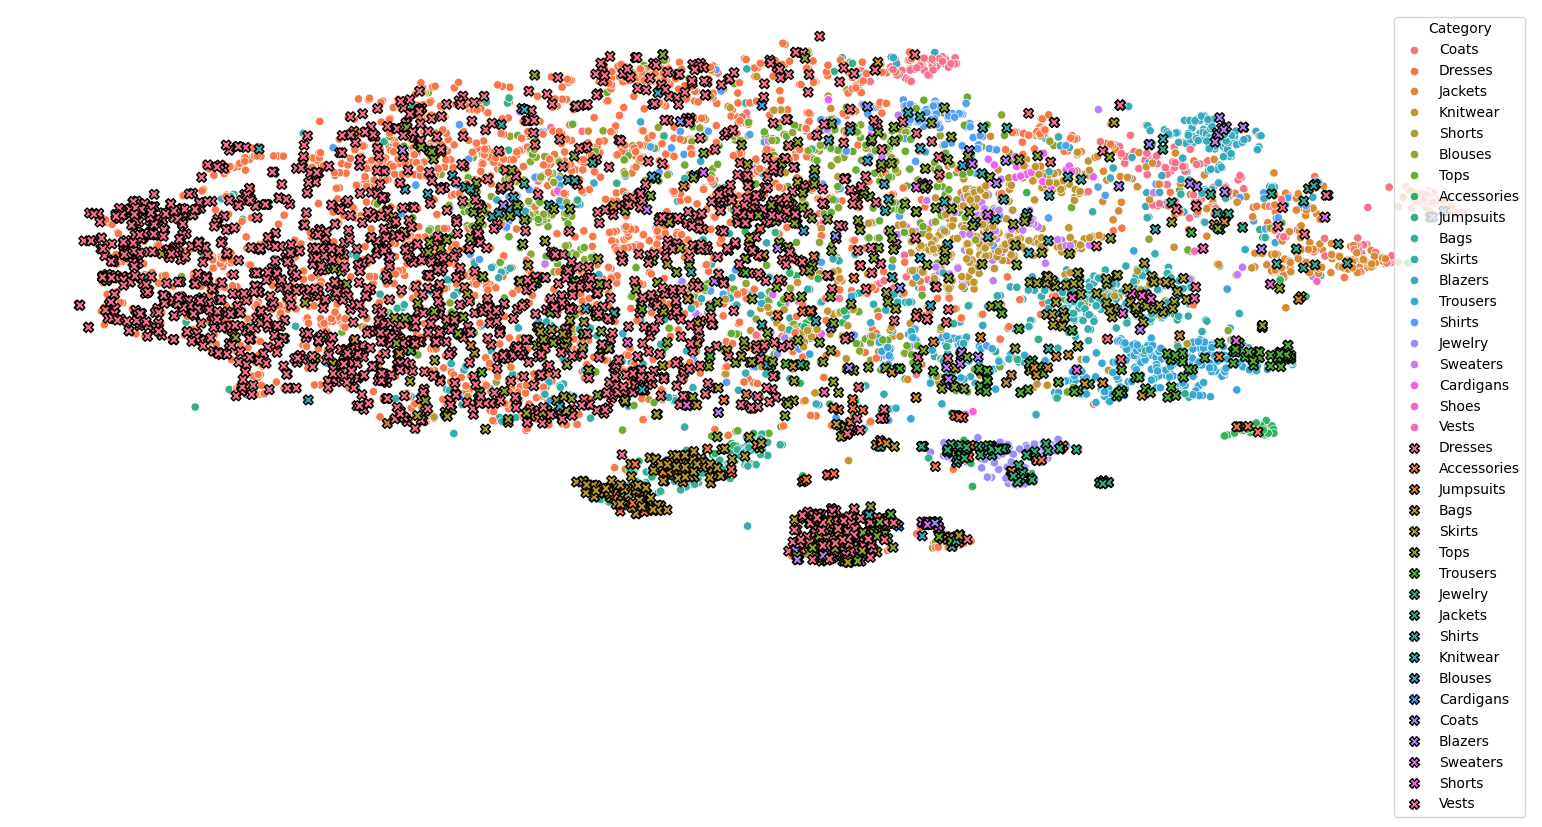

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from src import generate_embedding_tsnes_with_thumbnails

FIGURE_SAVE_PATH = "reports/figures/outfit_tsne.png"

#Generate TSNE diagram of embeddings, but only for outfits with at least one picture
#Save this graph to file to load it into PIL for later editing
tsne_df, scatter_plot = generate_embedding_tsnes_with_thumbnails.generate_tsne_diagram(embeddings_df, "outfit_embeddings", mark_points=embeddings_df["custom_category"] == "No positive examples", show_plot=True, save_path=FIGURE_SAVE_PATH)